<a href="https://colab.research.google.com/github/SKam23/Smile-Detector/blob/main/SmileDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile Detector
_**Authors:** by Shaheer Aslam, Steven Kam, and Sajan Shah_

## Introduction
For our ML Final Project, we have decided to classify human faces as smiling or not smiling. To do so, we trained multiple models that take in as input an image of a person's face and output whether the person is smiling or not. We used a subset of the Kaggle CelebA dataset to train our models which uses over 10,000 images of celeberity faces. We trained a total of four models to represent different problem statements. These include a CNN with regularization, FCNN, pretrained MobileNet model, and a CNN without regularization.

Through this project, we hope to compare and contrast the differences among the training/validation accuracy and losses among the different models. Specifically, we are looking at the difference in accuracy and loss between the CNN with regularization and the FCNN as the FCNN lacks convolutional layers which are critical for image processing. We are also looking to compare the CNN with regularization to the CNN without regularization as there should be a stark contrast in overfitting between the two models. We also hope to see how the more complex pretrained MobileNet model compares with our models to see how more convolutional layers can affect training/validation loss and accuracy.

Our project has foundations in facial recognition and image detection where we can use neural networks to classify images. Our network classifies into two groups of smiling and not similing but applications of similar classification problems are limitless as we can classify into multiple classes or relay more complex features of computer vision. Overall, our project lays the groundwork for classification and image detection problems and has many applications within computer vision.

### Scientific Question - what is the effect of regularization on CNNs for my dataset?
We will be considering the effect of regularization and comparing the results of the CNN we created, plotting both the regularized and non-regularized CNN models. With these plots which we will see later, we show our analysis and conclusions about the effect of regularization.

**MODIFY THE BELOW FLAG**
* True: Runs training and sets models, losses, accuracies accordingly / runs on GPU
* False: Doesn't run training, but loads saved models and parameters / runs on CPU

In [68]:
train_flag = False

# **Runtime Type**
We STRONGLY suggest using GPU as the hardware accelerator - we don't want you running it otherwise and having to leave your computer running for days on end when it could take minutes!

## Library Imports
All necessary libraries and packages are imported

In [69]:
import importlib

# torch imports
import torch 
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision import models

# data library imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

# other imports (cv2, PIL, etc.)
import random
import os
from PIL import Image
from IPython.display import display
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from tensorflow.keras.utils import img_to_array
import csv
import cv2
import PIL
import io
import html
import time

# CelebA Dataset Processing
We preprocess the Kaggle CelebA Dataset (https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) using a dictionary data structure that maps each image id to the image itself. We then partition the dataset into a training, validation, and testing dataset where each image is randonly placed into a dataset such that 80% of the Kaggle dataset is training, 10% is validation, and 10% is testing. We then create a class for our Dataset that contains two functionalities: find the length of the dataset and given an index of the dataset, return the image associated with that index and whether it is smiling or not.

In [70]:
!git clone https://github.com/SKam23/SmileData.git

fatal: destination path 'SmileData' already exists and is not an empty directory.


In [71]:
# load images into a dictionary for easier access
images = {}
for filename in os.listdir('./SmileData/selected_images10k/'):
    if filename.endswith('.jpg'):
        image = Image.open(os.path.join('./SmileData/selected_images10k/', filename))
        images[filename] = image


In [72]:
# list_eval_partition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
# list_bbox_celeba.csv: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
# list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
# list_attr_celeba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative
partition_df = pd.read_csv('./SmileData/list_eval_partition10000Smile.csv')
bbox_df = pd.read_csv('./SmileData/list_bbox_celeba10000Smile.csv')
landmarks_df = pd.read_csv('./SmileData/list_landmarks_align_celeba10000Smile.csv')
attr_df = pd.read_csv('./SmileData/list_attr_celeba10000Smile.csv')

# creating train, test, val dataframes
merged_df = partition_df.merge(bbox_df, on='image_id').merge(landmarks_df, on='image_id').merge(attr_df, on='image_id')
train_df = merged_df[merged_df['partition'] == 0]
val_df = merged_df[merged_df['partition'] == 1]
test_df = merged_df[merged_df['partition'] == 2]

In [73]:
# CelebA Dataset class, where __getitem__ corresponds to label "Smiling" or "Not Smiling", images resized to 178, 178
class CelebADataset(Dataset):
    def __init__(self, df, images):
        self.df = df
        self.images = images
        self.transform = transforms.Compose([transforms.Resize((178, 178)),transforms.ToTensor(),])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx, random = False):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        image = self.images[image_id]
        image = self.transform(image)
        is_smiling = row["Smiling"] == 1
        label = 1 if is_smiling else 0
        if random:
          return image, (label, image_id)
        else:
          return image,label

In [74]:
# loading training, validation, testing from CelebADataset
train_dataset = CelebADataset(train_df, images)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CelebADataset(val_df, images)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CelebADataset(test_df, images)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [75]:
# random images functino, gets two random images (smiling, not smiling) from first 1000 images
def get_random_images(dataset):
    smile_images = []
    not_smile_images = []
    
    for i in range(1000):
        image, label = train_dataset.__getitem__(i, True)
        if label[0] == 1:
            smile_images.append(dataset.images[label[1]])
        else:
            not_smile_images.append(dataset.images[label[1]])
    smile_image = random.choice(smile_images)
    not_smile_image = random.choice(not_smile_images)

    
    return smile_image, not_smile_image


## Example of Smiling / Not Smiling
We obtain two random images from the training dataset and display them below on a plot. One image will be classified as smiling while the other will be classified as not smiling. The x and y axes represent image dimensions. 

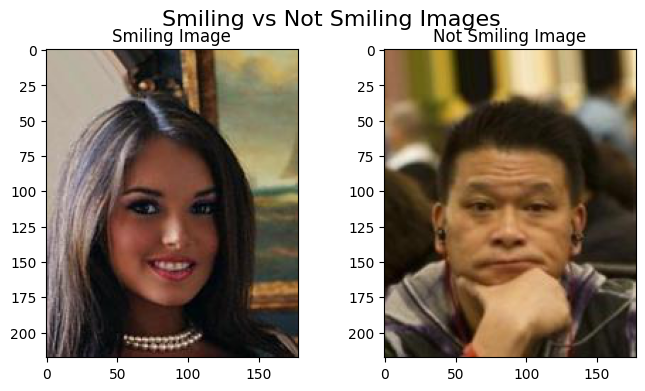

In [76]:
young_image, not_young_image = get_random_images(train_dataset)

# Create a figure and set title
fig = plt.figure(figsize=(8, 4))
fig.suptitle('Smiling vs Not Smiling Images', fontsize=16)

# Add young image to subplot 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(young_image)
ax1.set_title('Smiling Image')

# Add not young image to subplot 2
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(not_young_image)
ax2.set_title('Not Smiling Image')

plt.show()

# Methods
We model both convolutional neural networks and fully connected neural networks. We create one class for each type of network resulting in different forward propogation for each network. We also train our model on the pretrained MobileNet dataset while creating another class to depresent this dataset. We train each model using a cross entropy loss objective function. We also use the Adam algorithm which is a first-order gradient-based optimization algorithm for back propogation. As we train, we accumulate the training loss using cross entropy loss and the training accuracy using classification error rate. Once the model is trained, it is ran on the validation dataset where the validation loss and accuracy are are also calculated. For the convolutional neural network with regularization, we use a dropout regularizer which drops certain convolutional layers at random to help simplify our model and moderate overfitting. The dropout rate hyperparameter is initalliy set to 50% but can be modified as needed.

In [77]:
# CNN class, implementing our own convolutional neural network with 2 convolutional layers, 2 fully connected layers, a regularization option
# Uses relu for each convolutional layer and performs max pooling after each convolution
class CNN(nn.Module):
    def __init__(self, regularize = True):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 44 * 44, 128)
        self.fc2 = nn.Linear(128, 2)
        self.regularize = regularize
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if self.regularize:
          x = self.dropout(x)
        x = self.fc2(x)
        return x

In [78]:
# FCNN class, implementing our own fully connected neural network wth 3 fully connected layers, ReLU activation layers, and regularization
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(3 * 178 * 178, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return x


In [79]:
# MobileNet class, implementing MobileNet CNN from PyTorch with pretrained parameter, using average pooling layers
class MobileNet(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2(weights=pretrained)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        x = self.model.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        return x


In [80]:
# training function - given model, train_dataloader, num_epochs, and FCNN parameter (indicates whether model is FCNN),
# trains data and validates it for num_epochs and returns the model, train/val losses and train/val accuracies
def train(model, train_dataloader, val_dataloader, num_epochs, FCNN=False):
    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # initialize losses, accuracies
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # creating device variable depending on GPU usage
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        # training loop
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # loop over data
        for inputs, targets in train_dataloader:
          optimizer.zero_grad()
          if FCNN:
            inputs = inputs.view(inputs.size(0), -1)  # flatten input

          # send data to device
          inputs = inputs.to(device)
          targets = targets.to(device)
          outputs = model(inputs)

          # step optimization, backwards loss, update loss, total, correct
          _, predicted = torch.max(outputs.data, 1)
          targets_onehot = F.one_hot(targets, num_classes=2).float().to(device)  # convert targets to one-hot format
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_total += targets.size(0)
          train_correct += (predicted == targets).sum().item()

        # calculate epoch loss and accuracies
        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)
        train_acc = train_correct / train_total
        train_accs.append(train_acc)

        # validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            # loop over data
            for inputs, targets in val_dataloader:
                if FCNN:
                  inputs = inputs.view(inputs.size(0), -1)  # flatten input

                # send data to device
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                # step optimization, backwards loss, update loss, total, correct
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
            
            # calculate epoch loss and accuracies
            val_loss /= len(val_dataloader.dataset)
            val_losses.append(val_loss)
            val_acc = val_correct / val_total
            val_accs.append(val_acc)

        # print progress
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs


In [83]:
# function which loads models
def loadModels():
  # getting device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # loading model dictionaries
  nonreg_modelDict = torch.load('./SmileData/models/nonreg-CNN-Model.pt', map_location = device)
  modelDict = torch.load('./SmileData/models/CNN-Model.pt', map_location = device)
  FCNNmodelDict = torch.load('./SmileData/models/FCNN-Model.pt', map_location = device)
  pFCNmodelDict = torch.load('./SmileData/models/MobileNetV2-Model.pt', map_location = device)

  # creating empty models, loading in params
  nonreg_model, model, FCNNmodel, pFCNmodel = CNN(False), CNN(), FCNN(), MobileNet(True)
  nonreg_model.load_state_dict(nonreg_modelDict)
  model.load_state_dict(modelDict)
  FCNNmodel.load_state_dict(FCNNmodelDict)
  pFCNmodel.load_state_dict(pFCNmodelDict)

  # sending models to device, returning
  nonreg_model = nonreg_model.to(device)
  model = model.to(device)
  FCNNmodel = FCNNmodel.to(device)
  pFCNmodel = pFCNmodel.to(device)
  return nonreg_model, model, FCNNmodel, pFCNmodel

# function which loads losses / accs data
def getLossesAccs(filename):
  # open the file in read mode
  with open(filename, mode='r') as file:
    # create a csv reader object
    reader = csv.reader(file)
    # read the header row and discard it
    header = next(reader)
    # initialize empty lists to store the data
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # read the data rows and append the values to the corresponding lists
    for row in reader:
        train_losses.append(float(row[0]))
        val_losses.append(float(row[1]))
        train_accs.append(float(row[2]))
        val_accs.append(float(row[3]))
    return train_losses, val_losses, train_accs, val_accs

# Training
We either train our model using our train function above, or it is loaded in from an external source. If the train_flag = true, our models are trained using the train function above; otherwise, we load them in from an external source. Along with our trained model, we receive the training/validation loss along with the training/validation accuracy.

In [84]:
# if train flag is true, we train the models and get losses, accs
if train_flag:
  mobilenet = torchvision.models.mobilenet_v2()
  nonreg_model, nonreg_train_losses, nonreg_val_losses, nonreg_train_accs, nonreg_val_accs = train(CNN(False), train_dataloader,val_dataloader,10)
  print("Non-regularized CNN Model done training!")
  model, train_losses, val_losses, train_accs, val_accs = train(CNN(), train_dataloader,val_dataloader,10)
  print("Regularized CNN Model done training!")
  FCNmodel, FCNtrain_losses, FCNval_losses, FCNtrain_accs, FCNval_accs =   train(FCNN(), train_dataloader,val_dataloader,10, True)
  print("FCNN Model done training!")
  pFCNmodel, pFCNtrain_losses, pFCNval_losses, pFCNtrain_accs, pFCNval_accs = train(MobileNet(True), train_dataloader,val_dataloader,10, False)
  print("Pretrained MobileNet Model done training!")
# otherwise, load them in
else:
  # load models
  nonreg_model, model, FCNNmodel, pFCNmodel = loadModels()
  # loading losses & accuracies from github
  train_losses, val_losses, train_accs, val_accs = getLossesAccs("./SmileData/losses-accuracies/CNN-Data.csv")
  FCNtrain_losses, FCNval_losses, FCNtrain_accs, FCNval_accs = getLossesAccs("./SmileData/losses-accuracies/FCNN-Data.csv")
  pFCNtrain_losses, pFCNval_losses, pFCNtrain_accs, pFCNval_accs = getLossesAccs("./SmileData/losses-accuracies/MobileNetV2-Data.csv")
  nonreg_train_losses, nonreg_val_losses, nonreg_train_accs, nonreg_val_accs = getLossesAccs("./SmileData/losses-accuracies/nonreg-CNN-Data.csv")
  

# Results

## Plotting Training vs. Validation (Losses & Accuracies)

We plot the training vs validation statistics for each of the four models created. 

In [85]:
# taken from ML HW #7
def plotStatistics(model_name, epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs)
    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.set_title(f"{model_name} Loss")
    axis.grid()
    axis.legend()
    
    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.set_title(f"{model_name} Accuracy")
    axis.grid()
    axis.legend()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.tight_layout(pad=2)

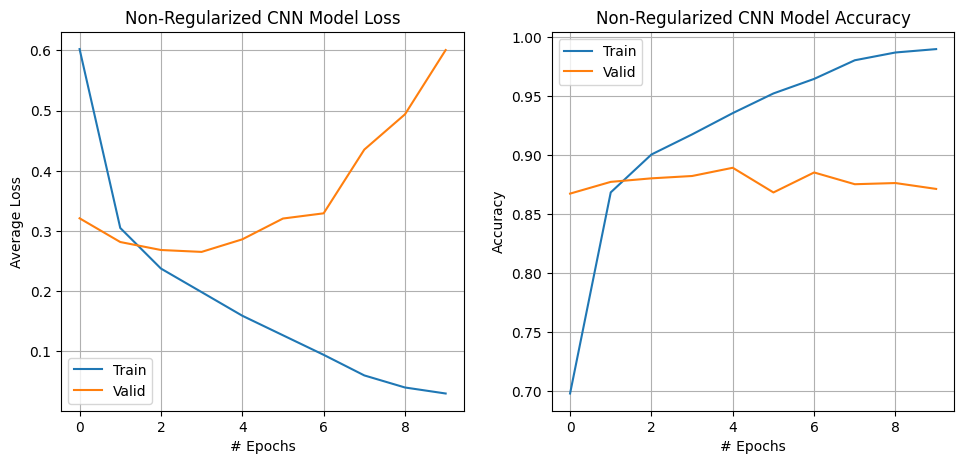

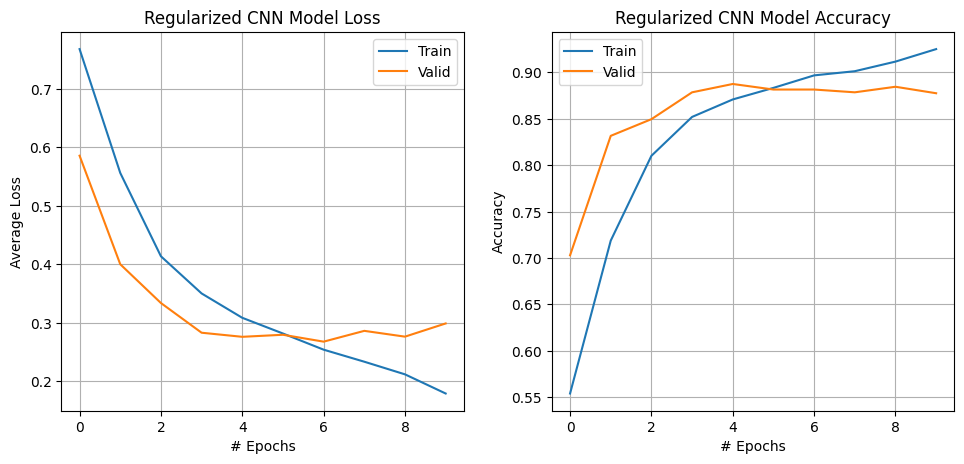

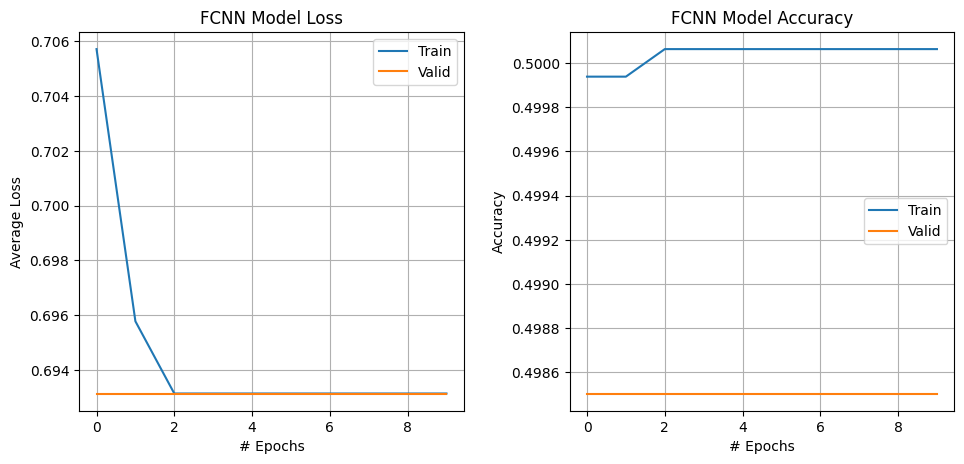

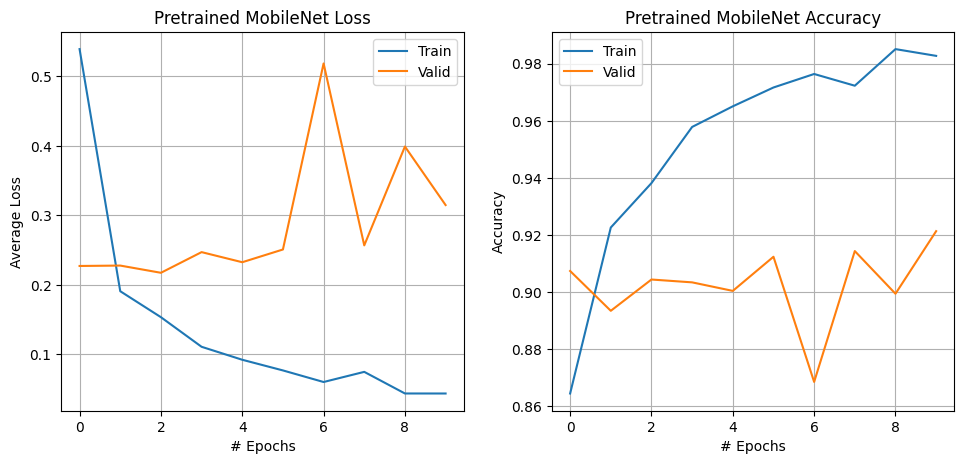

In [86]:
plotStatistics("Non-Regularized CNN Model", 10, nonreg_train_losses, nonreg_train_accs, nonreg_val_losses, nonreg_val_accs)
plotStatistics("Regularized CNN Model", 10, train_losses, train_accs, val_losses, val_accs)
plotStatistics("FCNN Model", 10, FCNtrain_losses, FCNtrain_accs, FCNval_losses, FCNval_accs)
plotStatistics("Pretrained MobileNet", 10, pFCNtrain_losses, pFCNtrain_accs, pFCNval_losses, pFCNval_accs)

# Discussion

## Analyzing model performances

Across our three models, the pretrained MobileNet model performs the best with a an accuracy of 0.92 on the validation dataset and 0.98 on the training dataset. The pretrained model is already able to acquire features and is trained on external data, so it performs slightly better when trained on our CelebA dataset than our raw CNN. Our self-made CNN follows right behind, while the fully connected network performs the worst amongst the three. The training accuracy for the regularized CNN lies at around 0.9 for both the validation and training datasets. For the unregularized CNN, we see that the training accuracy is near perfect at 0.98 while the validation accuracy lies at around 0.85. This strongly suggests overfitting on the unregularized CNN as we see the validation accuracy is much less then the training accuracy. On the other hand, our FCNN performs horribly with a training and validation accruacy near 0.5. The FCNN struggles to recognize features whatsoever from an image structure. Our FCNN also lacks convolutional layers which explains its inability to classify the images based on the features. This comparison shows exactly why CNNs are infinitely better than fully connected networks at training and testing on images, proving to be a much stronger model.

# Testing With Custom Images

In [90]:
def predict(img):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  new_image = img.resize((178, 178))
  new_image = np.array(new_image)/255.0
  new_image = (new_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
  new_image = torch.Tensor(new_image.transpose(2, 0, 1)).unsqueeze(0) # Add batch dimension
  new_image = new_image.to(device)
  
  model.eval()
  with torch.no_grad():
      outputs = model(new_image)
  _, predicted = torch.max(outputs.data, 1)

  # Get the predicted class name
  class_names = {0: 'Not Smile', 1: 'Smile'}
  predicted_class = class_names[predicted.item()]
  return predicted_class

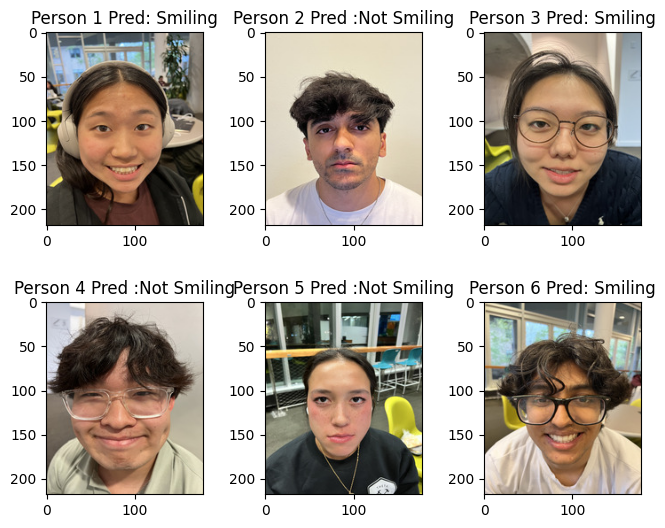

In [91]:
def display_images():
    # Load the images
    person1 = Image.open("./SmileData/testImg/EmilySmile178x218.jpeg")
    person3 = Image.open("./SmileData/testImg/YermSmile178x218.jpeg")
    person2 = Image.open("./SmileData/testImg/ShaNot178x218.jpeg")
    person4 = Image.open("./SmileData/testImg/MikeSmile178x218.jpeg")
    person5 = Image.open("./SmileData/testImg/KaiNot178x218.jpeg")
    person6 = Image.open("./SmileData/testImg/SajSmile178x218.jpeg")
    
    # Create a figure and axis objects
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
    
    # Display the images and set titles
    for i, img in enumerate([person1, person2, person3,
                             person4, person5, person6]):
        row = i // 3
        col = i % 3
        pred = predict(img) # acutaly prediction 
        title = f"Person {row * 3 + col + 1}{( ' Pred: Smiling' if pred == 'Smile' else ' Pred :Not Smiling')}"
        axs[row, col].imshow(img)
        axs[row, col].set_title(title)
    
    # Set the spacing and display the plot
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()
display_images()

# Test It Yourself!

Below is a modified script pulled from Colab and another resource, which is followed by a cell where we tell you in live time through the camera whether you are smiling / not smiling!



CITE THIS IN CITATIONS AND REFERENCES https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=09b_0FAnUa9y

In [92]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [93]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [100]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

def smileDetector():
  # initialize the Haar Cascade face detection model
  face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
  # start streaming video from webcam
  video_stream()
  # creating device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # label for video
  label_html = 'Capturing...'
  # initialze bounding box to empty
  bbox = ''
  count = 0 
  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])

      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      # grayscale image for face detection
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      # do prediction on img
      # get face region coordinates
      faces = face_cascade.detectMultiScale(gray)
      # get face bounding box for overlay
      for (x,y,w,h) in faces:
        try:
          # code for writing smiling/not smiling
          roi = cv2.resize(img[y - 50:y + h + 50, x - 50:x + w + 50], (178, 178))
          cv2.imwrite("roi.png", roi)
          # roi = np.stack((roi,) * 3, axis=-1)
          roi = np.transpose(roi, (2, 0, 1))
          roi = roi.astype('float') / 255.0
          roi = img_to_array(roi)
          roi = np.expand_dims(roi, axis = 0)
          roi = torch.Tensor(roi).to(device)
          res = model(roi)
          _, predicted = torch.max(res.data, 1)
          if (predicted.item()):
            cv2.putText(bbox_array, "Smiling", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
          else:
            cv2.putText(bbox_array, "Not Smiling", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)
            bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
        except:
          cv2.putText(bbox_array, "Trying", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
          bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,0,255),2)
      

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

## Live Time Smile Detection

Run the following cell to open up your camera and see in live time whether you're smiling or not! We STRONGLY suggest you avoid wearing glasses / covering your face, and have the best lighting possible (use a phone flashlight if necessary). This will give you the best results - sit relatively close to your computer as well.

In [ ]:
smileDetector()